# CNN_A SETTINGS

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np                
import warnings
import string
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale


contributor_selected = "I"                                 
contributor_train_file_path = '../data/Contributor_' + contributor_selected + '_Train.mat'
contributor_test_file_path = '../data/Contributor_' + contributor_selected + '_Test.mat'
channel_name_file_path = '../data/channels.csv'
channels = [i for i in range(64)]
warnings.filterwarnings('ignore')

# Training set processing

1.   Application of bandpass filter **(0.1-20Hz)**;
2.   Down-sampling signals from 240Hz to 120Hz;
3.   Obtain windows of 650ms at the start of every flashing (175ms)
4.   Normalization of samples in each window: **Zi = (Xi - mu) / sigma**;
5.   Reshape each window to be a 3D tensor with dimensions: **(N_SAMPLES, 78, 64)**;
6.   Obtain **(noP300 / P300)** class ratio to balance out dataset during training;

In [2]:
from scipy.io import loadmat
from scipy import signal
from bundle.DataCraft import * 

data_train = loadmat(contributor_train_file_path)
signals_train = data_train['Signal']
flashing_train = data_train['Flashing']
stimulus_train = data_train['StimulusType']
word_train = data_train['TargetChar']
sampling_frequency = 240
repetitions = 15
recording_duration_train = (len(signals_train)) * (len(signals_train[0])) / (sampling_frequency * 60)
trials_train = len(word_train[0])

print("Train Data:")
print_data(signals_train, word_train, contributor_selected, sampling_frequency)

Train Data:
Contributor     Sampling Freq. (Hz)  Recording (min)      Trials     Spelled Word                  
I               240.00               46.01                85         EAEVQTDOJG8RBRGONCEDHCTUIDBPUH
                                                                     MEM6OUXOCFOUKWA4VJEFRZROLHYNQD
                                                                     W_EKTLBWXEPOUIKZERYOOTHQI     


In [3]:
# Application of butterworth filter
b, a = signal.butter(4, [0.1 / sampling_frequency, 20 / sampling_frequency], 'bandpass')
for trial in range(trials_train):
    signals_train[trial, :, :] = signal.filtfilt(b, a, signals_train[trial, :, :], axis=0)
    
# Down-sampling of the signals from 240Hz to 120Hz
down_sampling_frequency = 120
SCALE_FACTOR = round(sampling_frequency / down_sampling_frequency)
sampling_frequency = down_sampling_frequency

print("# Samples of EEG signals before downsampling: {}".format(len(signals_train[0])))

signals_train = signals_train[:, 0:-1:SCALE_FACTOR, :]
flashing_train = flashing_train[:, 0:-1:SCALE_FACTOR]
stimulus_train = stimulus_train[:, 0:-1:SCALE_FACTOR]

print("# Samples of EEG signals after downsampling: {}".format(len(signals_train[0])))

# Samples of EEG signals before downsampling: 7794
# Samples of EEG signals after downsampling: 3897


In [4]:
# Number of EEG channels
N_CHANNELS = len(channels)
# Window duration after each flashing [ms]
WINDOW_DURATION = 650
# Number of samples of each window
WINDOW_SAMPLES = round(sampling_frequency * (WINDOW_DURATION / 1000))
# Number of samples for each character in trials
SAMPLES_PER_TRIAL = len(signals_train[0])

train_features = []
train_labels = []

count_positive = 0
count_negative = 0

for trial in range(trials_train):
    for sample in (range(SAMPLES_PER_TRIAL)):
        if (sample == 0) or (flashing_train[trial, sample - 1] == 0 and flashing_train[trial, sample] == 1):
            lower_sample = sample
            upper_sample = sample + WINDOW_SAMPLES
            window = signals_train[trial, lower_sample:upper_sample, :]                
            # Features extraction
            train_features.append(window)
            # Labels extraction
            if stimulus_train[trial, sample] == 1:
                count_positive += 1
                train_labels.append(1) # Class P300
            else:
                count_negative += 1
                train_labels.append(0) # Class no-P300

# Get negative-positive classes ratio
train_ratio = count_negative/count_positive

# Convert lists to numpy arrays
train_features = np.array(train_features)
train_labels = np.array(train_labels)

# 3D Tensor shape (SAMPLES, 64, 78)
dim_train = train_features.shape
print("Features tensor shape: {}".format(dim_train))

# Data normalization Zi = (Xi - mu) / sigma
for pattern in range(len(train_features)):
    train_features[pattern] = scale(train_features[pattern], axis=0)

Features tensor shape: (15300, 78, 64)


# Testing set processing

1.   Application of bandpass filter **(0.1-20Hz)**;
2.   Down-sampling signas from 240Hz to 120Hz;
3.   Obtain windows of 650ms at the start of every flashing (175ms)
4.   Normalization of samples in each window: **Zi = (Xi - mu) / sigma**;
5.   Reshape each window to be a 3D tensor with dimensions: **(N_SAMPLES, 78, 64)**;
6.   Calculate weights vector to balance samples importance and obtain correct accuracy estimation;

In [5]:
from bundle.DataCraft import *  

data_test = loadmat(contributor_test_file_path)
signals_test = data_test['Signal']
flashing_test = data_test['Flashing']
word_test =  data_test['TargetChar']
stimulus_code_test = data_test['StimulusCode']
sampling_frequency = 240
repetitions = 15
recording_duration_test = (len(signals_test)) * (len(signals_test[0])) / (sampling_frequency * 60)
trials_test = len(word_test[0])
samples_per_trial_test = len(signals_test[0])

print("Test Data:")
print_data(signals_test, word_test, contributor_selected, sampling_frequency)

Test Data:
Contributor     Sampling Freq. (Hz)  Recording (min)      Trials     Spelled Word                  
I               240.00               54.12                100        WQXPLZCOMRKO97YFZDEZ1DPI9NNVGR
                                                                     QDJCUVRMEUOOOJD2UFYPOO6J7LDGYE
                                                                     GOA5VHNEHBTXOO1TDOILUEE5BFAEEX
                                                                     AW_K4R3MRU                    


In [6]:
char_matrix = [[0 for j in range(6)] for i in range(6)]
s = string.ascii_uppercase + '1' + '2' + '3' + '4' + '5' + '6' + '7' + '8' + '9' + '_'

# Append cols and rows in a list
list_matrix = []
for i in range(6):
    col = [s[j] for j in range(i, 36, 6)]
    list_matrix.append(col)
for i in range(6):
    row = [s[j] for j in range(i * 6, i * 6 + 6)]
    list_matrix.append(row)

# Create StimulusType array for the test set (missing from the given database)
stimulus_test = [[0 for j in range(samples_per_trial_test)] for i in range(trials_test)]
stimulus_test = np.array(stimulus_test)

for trial in range(trials_test):
    counter=0
    for sample in range(samples_per_trial_test):
        index = int(stimulus_code_test[trial, sample]) - 1
        if not index == -1:
            if word_test[0][trial] in list_matrix[index]:
                stimulus_test[trial, sample] = 1
            else:
                stimulus_test[trial, sample] = 0

In [7]:
# Application of butterworth filter
b, a = signal.butter(4, [0.1 / sampling_frequency, 20 / sampling_frequency], 'bandpass')
for trial in range(trials_test):
    signals_test[trial, :, :] = signal.filtfilt(b, a, signals_test[trial, :, :], axis=0)
    
# Down-sampling of the signals from 240Hz to 120Hz
down_sampling_frequency = 120
SCALE_FACTOR = round(sampling_frequency / down_sampling_frequency)
sampling_frequency = down_sampling_frequency

print("# Samples of EEG signals before downsampling: {}".format(len(signals_test[0])))

signals_test = signals_test[:, 0:-1:SCALE_FACTOR, :]
flashing_test = flashing_test[:, 0:-1:SCALE_FACTOR]
stimulus_test = stimulus_test[:, 0:-1:SCALE_FACTOR]

print("# Samples of EEG signals after downsampling: {}".format(len(signals_test[0])))

# Samples of EEG signals before downsampling: 7794
# Samples of EEG signals after downsampling: 3897


In [8]:
# Number of EEG channels
N_CHANNELS = len(channels)
# Window duration after each flashing [ms]
WINDOW_DURATION = 650
# Number of samples of each window
WINDOW_SAMPLES = round(sampling_frequency * (WINDOW_DURATION / 1000))
# Number of samples for each character in trials
samples_per_trial_test = len(signals_train[0])

test_features = []
test_labels = []
windowed_stimulus = []

count_positive = 0
count_negative = 0

for trial in range(trials_test):
    for sample in (range(samples_per_trial_test)):
        if (sample == 0) or (flashing_test[trial, sample-1] == 0 and flashing_test[trial, sample] == 1):
            lower_sample = sample
            upper_sample = sample + WINDOW_SAMPLES
            window = signals_test[trial, lower_sample:upper_sample, :]
            # Extracting number of row/col in a window
            number_stimulus = int(stimulus_code_test[trial, sample])
            windowed_stimulus.append(number_stimulus)
            # Features extraction
            test_features.append(window)
            # Labels extraction
            if stimulus_test[trial, sample] == 1:
                count_positive += 1
                test_labels.append(1) # Class P300
            else:
                count_negative += 1
                test_labels.append(0) # Class no-P300

# Get test weights to take into account the number of classes 
test_weights = []
for i in range(len(test_labels)):
    if test_labels[i] == 1:
        test_weights.append(len(test_labels)/count_positive)
    else:
        test_weights.append(len(test_labels)/count_negative)
test_weights = np.array(test_weights)

# Convert lists to numpy arrays
test_features = np.array(test_features)
test_labels = np.array(test_labels)

# 3D tensor (SAMPLES, 64, 78)
dim_test = test_features.shape
print("Features tensor shape: {}".format(dim_test))

# Data normalization Zi = (Xi - mu) / sigma
for pattern in range(len(test_features)):
    test_features[pattern] = scale(test_features[pattern], axis=0)

Features tensor shape: (18000, 78, 64)


# CNN_A model definition, training and testing

1.   Function definiton for randomization of weights and biases;
2.   **Scaled_tanh(x)** activation function definition;
3.   ANN model definition (2 Conv1D layers, 2 dense layers);
4.   Training of the network over weighted dataset;
5.   CNN1 performance assessment;

In [9]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K

# Randomizing function for bias and weights of the network
def cecotti_normal(shape, dtype=None):
    if len(shape) == 1:
        fan_in = shape[0]
    elif len(shape) == 2:
        fan_in = shape[0]
    else:
        receptive_field_size = 1
        for dim in shape[:-2]:
            receptive_field_size *= dim
        fan_in = shape[-2] * receptive_field_size
    stddev = 1.0 / fan_in
    return K.random_normal(shape, mean=0.0, stddev=stddev, dtype=dtype)

# Custom tanh activation function
def scaled_tanh(z):
    return 1.7159 * K.tanh((2.0 / 3.0) * z)

# Build the model
def CNN1_model(channels=64, filters=10):
    model = Sequential([
        Conv1D(
            filters=filters,
            kernel_size=1,
            padding="same",
            bias_initializer=cecotti_normal,
            kernel_initializer=cecotti_normal,
            use_bias=True,
            activation=lambda x: scaled_tanh(x),
            input_shape=(78, channels)
        ),
        Conv1D(
            filters=50,
            kernel_size=13,
            padding="valid",
            strides=11,
            bias_initializer=cecotti_normal,
            kernel_initializer=cecotti_normal,
            use_bias=True,
            activation=lambda x: scaled_tanh(x),
        ),
        Flatten(),
        Dense(100, activation="sigmoid"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    return model

# Training parameters
BATCH_SIZE = 256
EPOCHS = 200
VALID_SPLIT = 0.05
SHUFFLE = 1  # set to 1 to shuffle subsets during training

# Model summary
model = CNN1_model(channels=64, filters=10)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 78, 10)         │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 6, 50)          │         6,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,401 (146.10 KB)

 Trainable params: 37,401 (146.10 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Callback to stop when loss on validation set doesn't decrease in 50 epochs
earlystop = EarlyStopping(monitor='val_loss', 
                          mode='min', 
                          patience=50, 
                          restore_best_weights=True)

# Train the model and store history
history = model.fit(x=train_features, 
                    y=train_labels, 
                    validation_data=(test_features, test_labels),
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    validation_split=VALID_SPLIT, 
                    callbacks=[earlystop],
                    shuffle=SHUFFLE,
                    class_weight={0: 1., 1: train_ratio})

# Find the epoch with the lowest validation loss
best_epoch = np.argmin(history.history['val_loss'])
print(f"Best epoch: {best_epoch + 1} with validation loss: {history.history['val_loss'][best_epoch]}")

# Reload the best weights manually
best_weights = model.get_weights()
model.set_weights(best_weights)

# Define a new model to reuse the best configuration
best_model = CNN1_model(channels=64, filters=10)
best_model.set_weights(best_weights)

# Compile the best model
best_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

Epoch 1/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.4290 - loss: 0.4542 - val_accuracy: 0.7222 - val_loss: 0.1916
Epoch 2/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6879 - loss: 0.3506 - val_accuracy: 0.6431 - val_loss: 0.2273
Epoch 3/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7010 - loss: 0.3224 - val_accuracy: 0.6926 - val_loss: 0.2016
Epoch 4/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7243 - loss: 0.3204 - val_accuracy: 0.7127 - val_loss: 0.1899
Epoch 5/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7254 - loss: 0.3122 - val_accuracy: 0.7416 - val_loss: 0.1749
Epoch 6/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7367 - loss: 0.3087 - val_accuracy: 0.7523 - val_loss: 0.1691
Epoch 7/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7264 - loss: 0.3118 - val_accuracy: 0.7161 - val_loss: 0.1878
Epoch 8/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7294 - loss: 0.3067 - val_accuracy: 0.7

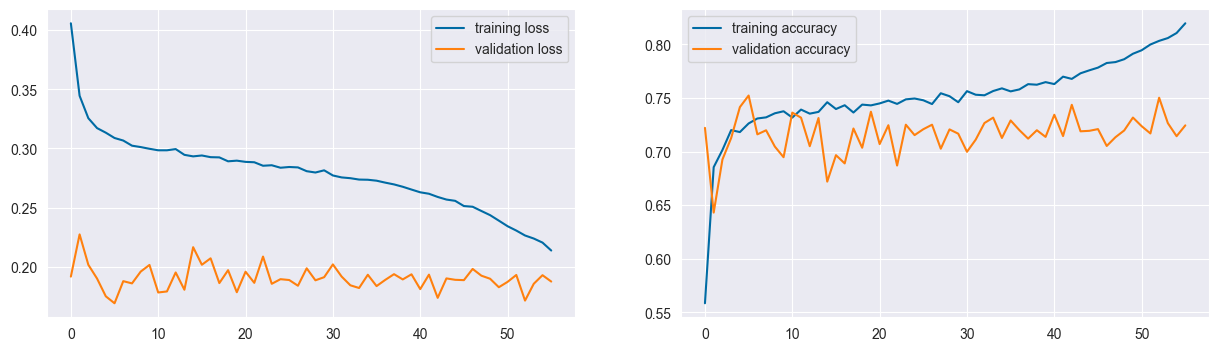

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,4))
plt.style.use('tableau-colorblind10')

# Plots of loss curves during training
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label="training loss")
plt.plot(history.history['val_loss'], label="validation loss")
plt.legend()

# Plots of accuracy curves during training
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label="training accuracy")
plt.plot(history.history['val_accuracy'], label="validation accuracy")
plt.legend()

plt.show()

['Fc5', 'Fc3', 'Fc1', 'Fcz', 'Fc2', 'Fc4', 'Fc6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'Cp5', 'Cp3', 'Cp1', 'Cpz', 'Cp2', 'Cp4', 'Cp6', 'Fp1', 'Fpz', 'Fp2', 'Af7', 'Af3', 'Afz', 'Af4', 'Af8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'Ft7', 'Ft8', 'T7', 'T8', 'T9', 'T10', 'Tp7', 'Tp8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'Po7', 'Po3', 'Poz', 'Po4', 'Po8', 'O1', 'Oz', 'O2', 'Iz']
[0, 1, 2, 3, 4, 5, 6, 14, 15, 16, 17, 18, 19, 20, 24, 25, 26, 27, 28, 38, 39, 44, 45, 55, 56, 57, 58, 59]
['C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'Fp1', 'Fpz', 'Fp2', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'T7', 'T8', 'T9', 'T10', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'O1', 'Oz', 'O2', 'Iz']


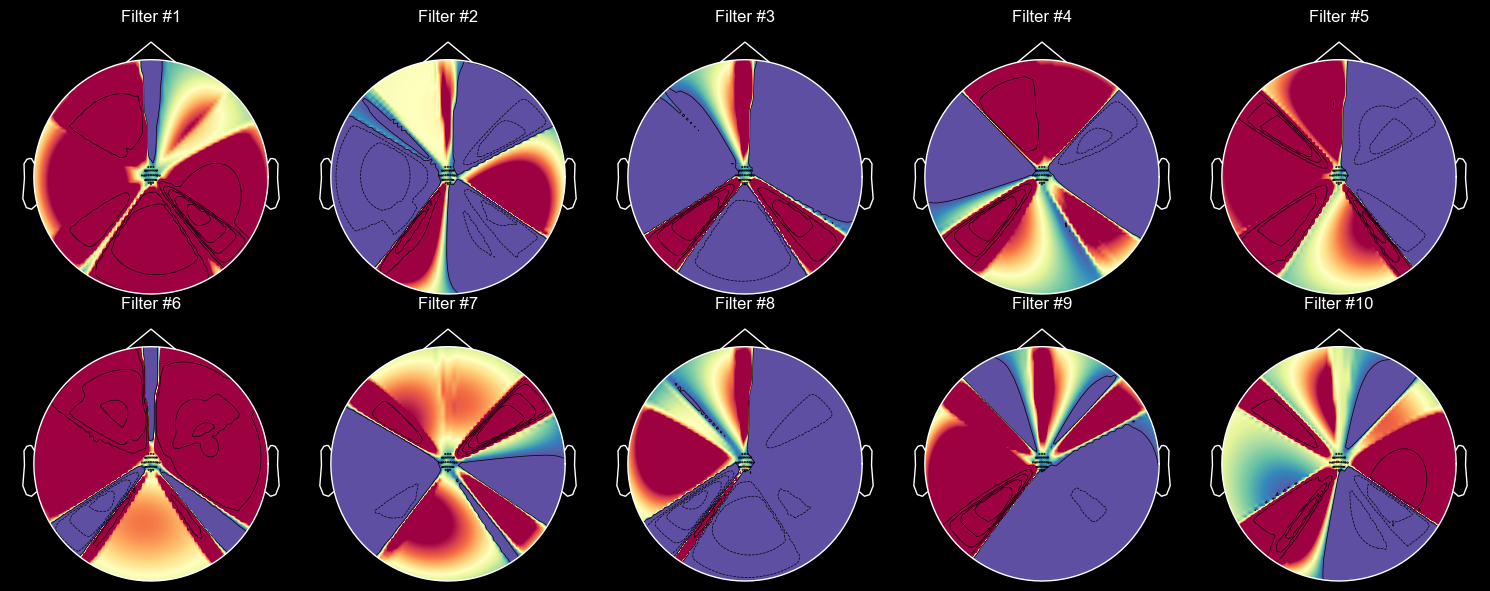

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import csv
from bundle.DataCraft import electrode_names_to_remove

# Read CSV file into a Python list
electrode_names = []

with open(channel_name_file_path, "r") as file:
    csv_reader = csv.reader(file)
    for row in csv_reader:
        electrode_names.extend(row)  # Add each row to the list (handles single-column CSV)

print(electrode_names)


# Create array has the original index for electrode_names_to_remove in electrode_names
index = []
for i in range(len(electrode_names_to_remove)):
    index.append(electrode_names.index(electrode_names_to_remove[i]))
print(index)

electrode_names = [x for x in electrode_names if x not in electrode_names_to_remove]
print(electrode_names)
    
    
montage = mne.channels.make_standard_montage("standard_1020")

# Create random weights for 10 filters (20 channels)
n_channels = len(electrode_names)
n_filters = 10

# Create a list of weights for all filters
nf = []
for filt in range(10):
    nf.append(abs(np.array(best_model.get_weights()[0])[0, :, filt]))
# remove the channels from the weights 
nf = np.delete(nf, index, axis=1)



# Create an Info object with EEG channel names
info = mne.create_info(ch_names=electrode_names, sfreq=1000, ch_types="eeg")
info.set_montage(montage)

# Plot topomap for each filter
# Set give me array of background color
fig, axes = plt.subplots(2, 5, figsize=(15, 6), facecolor="#000000")  # Set overall background to black
axes = axes.flatten()

for i in range(n_filters):
    ax = axes[i]
    mne.viz.plot_topomap(
        nf[i], info, axes=ax, cmap="Spectral_r", sphere=1.2, show=False  # Adjust `sphere` to scale brain size
    )
    ax.set_title(f"Filter #{i + 1}", color="white")  # Set title color to white for better visibility

plt.tight_layout()
plt.show()


In [13]:
# Accuracy over the testing set
predictions = best_model.predict(test_features)
predictions = np.round(predictions)

score = np.array(best_model.evaluate(test_features, test_labels, verbose=0, sample_weight=test_weights))
print("Model performance on test set:\t[ Loss: {}\tAccuracy: {} ]".format(*score.round(4)))
print("\nPredictions: {}\nSolutions:   {}".format(list(map(int, predictions))[:50], list(map(int, test_labels))[:50]))

563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model performance on test set:	[ Loss: 0.4044	Accuracy: 0.7523 ]

Predictions: [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1]
Solutions:   [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


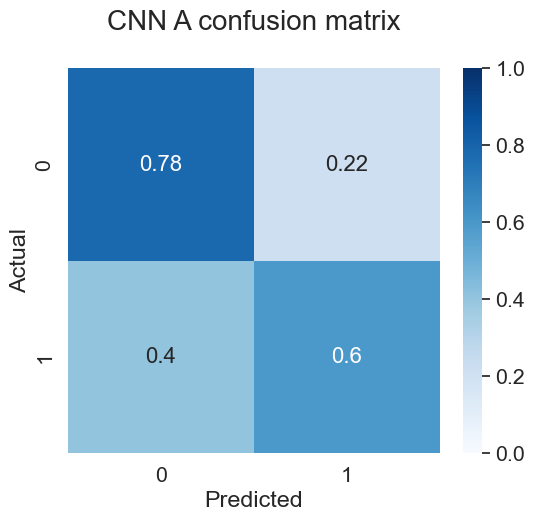

In [14]:
# Weighted confusion matrix (noP300: 80%, P300: 20%)
data_train = confusion_matrix(y_true=test_labels, y_pred=predictions, sample_weight=test_weights)

# Normalized confusion matrix (values in range 0-1)
data_norm = data_train / np.full(data_train.shape, len(test_labels))

# Plot the confusion matrix
df_cm = pd.DataFrame(data_norm, columns=np.unique(test_labels), index = np.unique(test_labels))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (6,5))
sns.set(font_scale = 1.4)
cm = sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws = {"size": 16}, vmin=0, vmax=1)
cm.axes.set_title("CNN A confusion matrix\n", fontsize=20)
plt.show()

In [15]:
# Model metrics (sens, spec, ppv, npv)
def model_metrics(conf_matrix):
    tn, fp, fn, tp = list(data_norm.flatten())
    sens = round(tp/(tp+fn),4) # Sensitivity
    spec = round(tn/(tn+fp),4) # Specificity
    ppv = round(tp/(tp+fp),4) # Positive Predicted Value
    npv = round(tn/(tn+fn),4) # Negative Predicted Value
    return {"Sensitivity":sens, "Specificity":spec, "PPV":ppv, "NPV":npv}

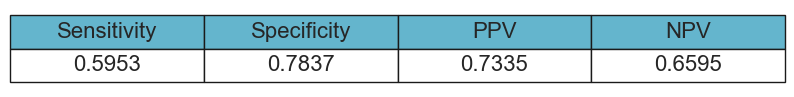

In [16]:
# Put model metrics into a table
metrics = model_metrics(data_norm)

# Create figure
fig = plt.figure(figsize=(5,1))
ax = fig.add_subplot(111)

# Hide graph outlines
for item in [fig, ax]:
    item.patch.set_visible(False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)

# Table definition
table = ax.table(cellText=[list(metrics.values())], 
                     colLabels=list(metrics.keys()),
                     loc="center",
                     cellLoc="center",
                     colColours=["c"]*4)
table.set_fontsize(16)
table.scale(2,2)

plt.show()